# Topic Discovery in Negative App Reviews

![wordcloud](wordcloud.png)

As a Data Scientist working for a mobile app company, you usually find yourself applying product analytics to better understand user behavior, uncover patterns, and reveal insights to identify the great and not-so-great features. Recently, the number of negative reviews has increased on Google Play, and as a consequence, the app's rating has been decreasing. 

Objective

The goal was to identify and understand common themes in negative app reviews (i.e., reviews with a rating of 1 or 2), using unsupervised learning techniques.

# Steps Completed
Filtering Negative Reviews

Reviews were filtered where the score was either 1 or 2.

Only the content of these reviews was used for analysis.

# Preprocessing

Reviews were lowercased and tokenized.

Stop words and non-alphabetic tokens were removed.

Cleaned tokens were joined back into strings.

# TF-IDF Vectorization

TF-IDF was applied to the cleaned reviews to quantify term importance while ignoring common but uninformative words.

# Clustering with K-means

Reviews were grouped into 5 clusters using K-means.

Each review was assigned to a cluster, stored as a new category label.

# Topic Extraction

For each cluster, the term with the highest total TF-IDF weight was extracted.

The results were stored in a summary table (topic_terms DataFrame) containing:

The cluster label (category)

The top term (term)

Its TF-IDF frequency (frequency)

# Visualization

A horizontal bar plot was created to illustrate the top term for each cluster based on TF-IDF score.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
# Download necessary files from NLTK:
# punkt -> Tokenization
# stopwords -> Stop words removal
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/repl/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/repl/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# Load the reviews dataset and preview it
reviews = pd.read_csv("reviews.csv")
reviews.head()

,content,score
0,I cannot open the app anymore,1
1,I have been begging for a refund from this app...,1
2,Very costly for the premium version (approx In...,1
3,"Used to keep me organized, but all the 2020 UP...",1
4,Dan Birthday Oct 28,1


In [4]:
# Filter negative reviews (score 1 or 2)
negative_reviews_tmp = reviews[reviews['score'].isin([1,2])]['content']

In [5]:
# Step 1: Simple text preprocessing: tokenization & text cleaning

example_review = "This app is terrible! Crashes all the time, not worth it."

# Tokenize the text
tokens = word_tokenize(example_review)

# Get English stop words
stop_words = set(stopwords.words('english'))

# Clean tokens: keep only alphabetic tokens and remove stop words
cleaned_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]

print(cleaned_tokens)

['app', 'terrible', 'crashes', 'time', 'worth']


In [6]:
# Define preprocessing function
def preprocess_review(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    # Keep only alphabetic tokens and remove stop words
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    
    # Rejoin tokens into a single string
    preprocessed_text = ' '.join(filtered_tokens)
    
    return preprocessed_text

In [7]:
# Apply the function to the entire Series
cleaned_reviews = negative_reviews_tmp.apply(preprocess_review)

# Create the final DataFrame
preprocessed_reviews = pd.DataFrame({'review': cleaned_reviews})

In [8]:
# Step 2: Vectorize the preprocessed negative reviews using TF-IDF 

# Instantiate the vectorizer 
vectorizer = TfidfVectorizer()

# Apply TF-IDF to the 'review' column of preprocessed reviews
tfidf_matrix = vectorizer.fit_transform(preprocessed_reviews['review'])

In [9]:
# Step 3: Clustering the vectorized reviews using K-means algorithm

# Instantiate the model with 5 clusters 
clust_kmeans = KMeans(n_clusters=5, random_state=42)

# Fit and predict cluster labels
predicted_labels = clust_kmeans.fit_predict(tfidf_matrix)

# Convert to list 
categories = predicted_labels.tolist()

In [10]:
# Identify the most frequent terms in each cluster

#  Loop through the unique cluster labels (categories) and for each cluster sum the TF-IDF scores for each term (column) in the cluster. It will help to get the top term and its frequency

# Get feature names from the vectorizer 
terms = vectorizer.get_feature_names_out()

# Store the results 
topic_terms = []

# Lopp over all 5 clusters 
for cluster_label in range(5):
    # Step 1: Get indices of reviews in the current cluster 
    cluster_indices = [i for i, label in enumerate(categories) if label == cluster_label]
    
    # Step 2: Sum TF-IDF scores across those reviews (axis=0 = column-wise)
    cluster_tfidf_sum = tfidf_matrix[cluster_indices].sum(axis=0)
    
    # Step 3: Convert to flat 1D array
    tfidf_scores = np.array(cluster_tfidf_sum).ravel()
    
    # Step 4: Get index of the most important term
    top_term_index = tfidf_scores.argmax()
    top_term = terms[top_term_index]
    frequency = tfidf_scores[top_term_index]
    
    # Step 5: Store in a list of dicts
    topic_terms.append({
        'category': cluster_label,
        'top_term': top_term,
        'frequency': frequency
    })

In [11]:
# Get the top terms and their frequencies 

import numpy as np
import pandas as pd

# Get feature names from the vectorizer
terms = vectorizer.get_feature_names_out()

# Prepare the list to collect topic info
topic_terms_list = []

# Loop through each cluster
for cluster_label in range(5):
    # 1. Get indices of reviews in this cluster
    cluster_indices = [i for i, label in enumerate(categories) if label == cluster_label]
    
    # 2. Get the summed TF-IDF vector for the cluster
    cluster_terms_freq = tfidf_matrix[cluster_indices].sum(axis=0)
    
    # 3. Flatten the matrix to a 1D array
    cluster_terms_freq = np.array(cluster_terms_freq).ravel()
    
    # 4. Find the index of the most frequent term
    top_term_index = cluster_terms_freq.argsort()[::-1][0]
    
    # 5. Create dictionary and add to the list
    topic_terms_list.append({
        'category': cluster_label,
        'term': terms[top_term_index],
        'frequency': cluster_terms_freq[top_term_index]
    })

topic_terms = pd.DataFrame(topic_terms_list)
topic_terms.head(10)

,category,term,frequency
0,0,account,51.159578
1,1,version,67.774684
2,2,calendar,75.887674
3,3,app,182.992085
4,4,good,37.173626


# Findings
Each cluster reveals a common pain point among users.

These insights can help developers prioritize fixes and UX improvements based on actual user complaints.

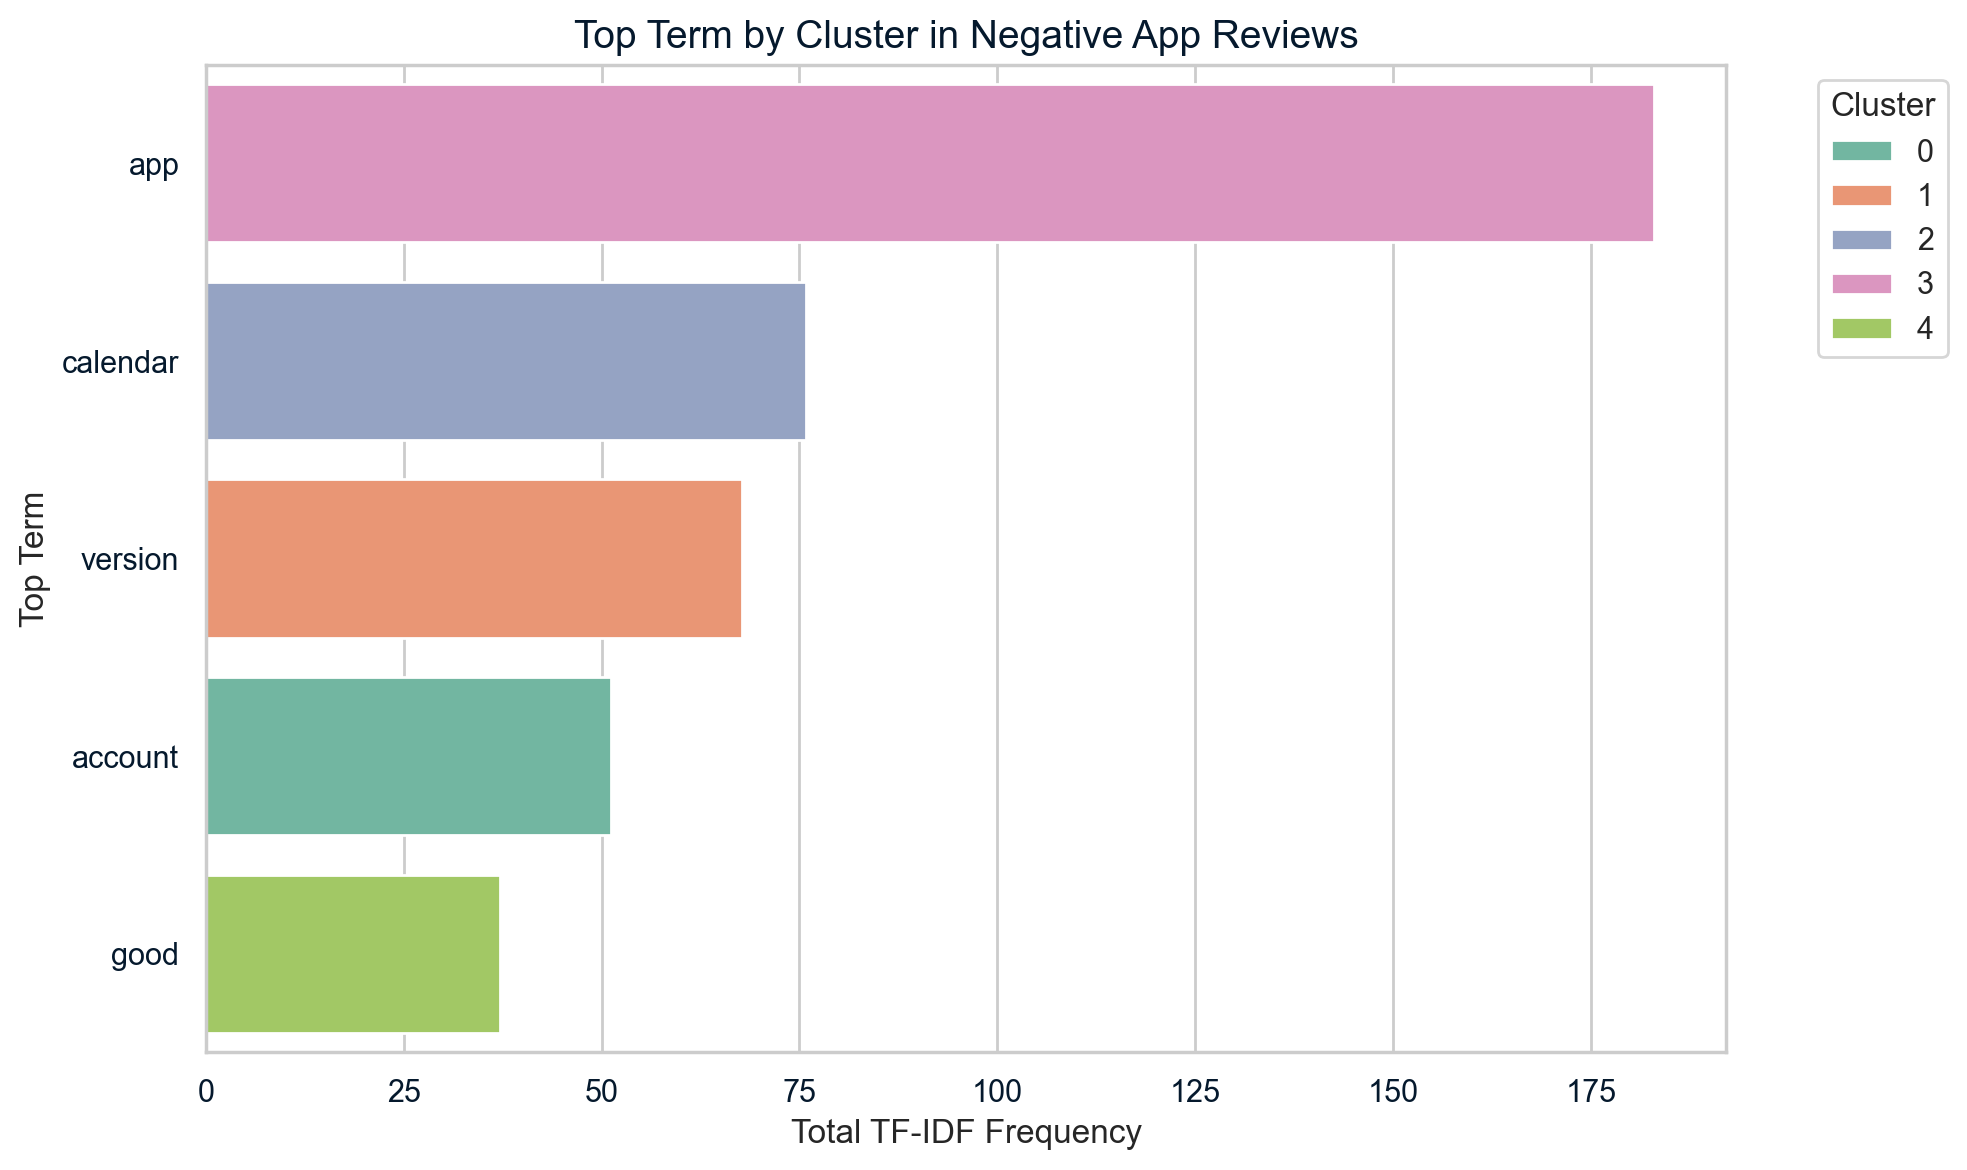

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=topic_terms.sort_values('frequency', ascending=False),
    y='term',
    x='frequency',
    hue='category',
    dodge=False,
    palette='Set2'
)

plt.title("Top Term by Cluster in Negative App Reviews", fontsize=14)
plt.xlabel("Total TF-IDF Frequency")
plt.ylabel("Top Term")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [13]:
top_n = 5
topic_terms_list = []

for cluster_label in range(5):
    cluster_indices = [i for i, label in enumerate(categories) if label == cluster_label]
    cluster_tfidf_sum = tfidf_matrix[cluster_indices].sum(axis=0)
    cluster_tfidf_sum = np.array(cluster_tfidf_sum).ravel()
    
    # Get top N indices in descending order
    top_term_indices = cluster_tfidf_sum.argsort()[::-1][:top_n]
    
    for idx in top_term_indices:
        topic_terms_list.append({
            'category': cluster_label,
            'term': terms[idx],
            'frequency': cluster_tfidf_sum[idx]
        })

# Create updated DataFrame
topic_terms = pd.DataFrame(topic_terms_list)

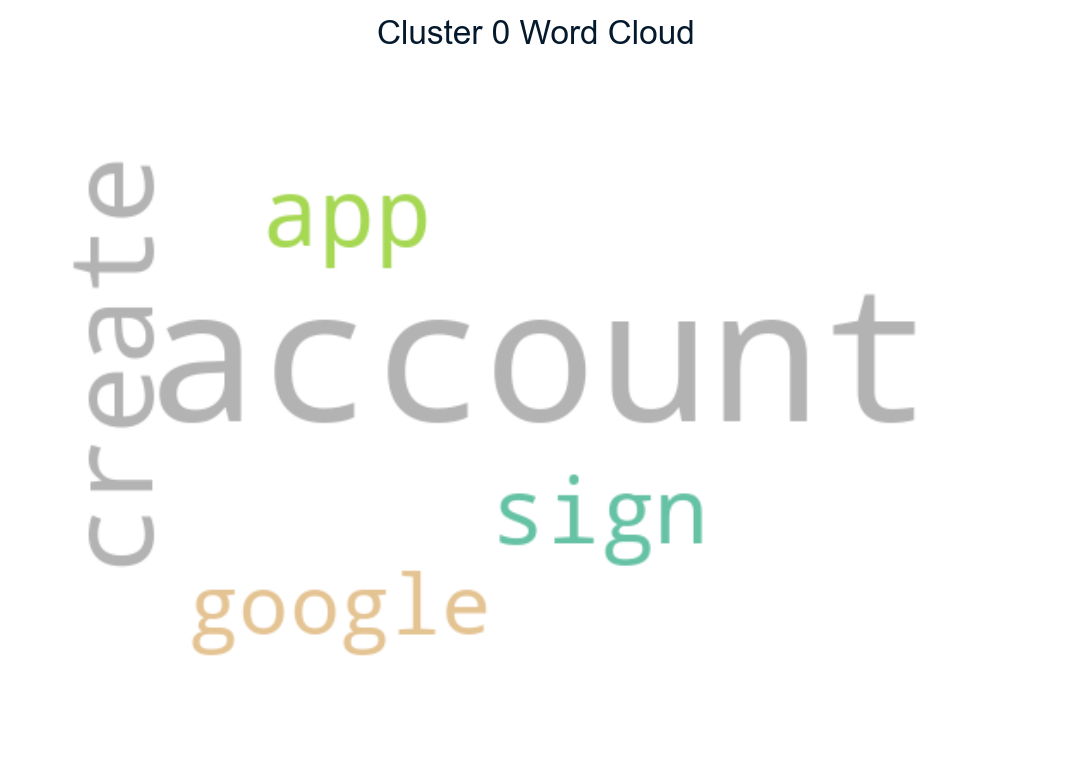

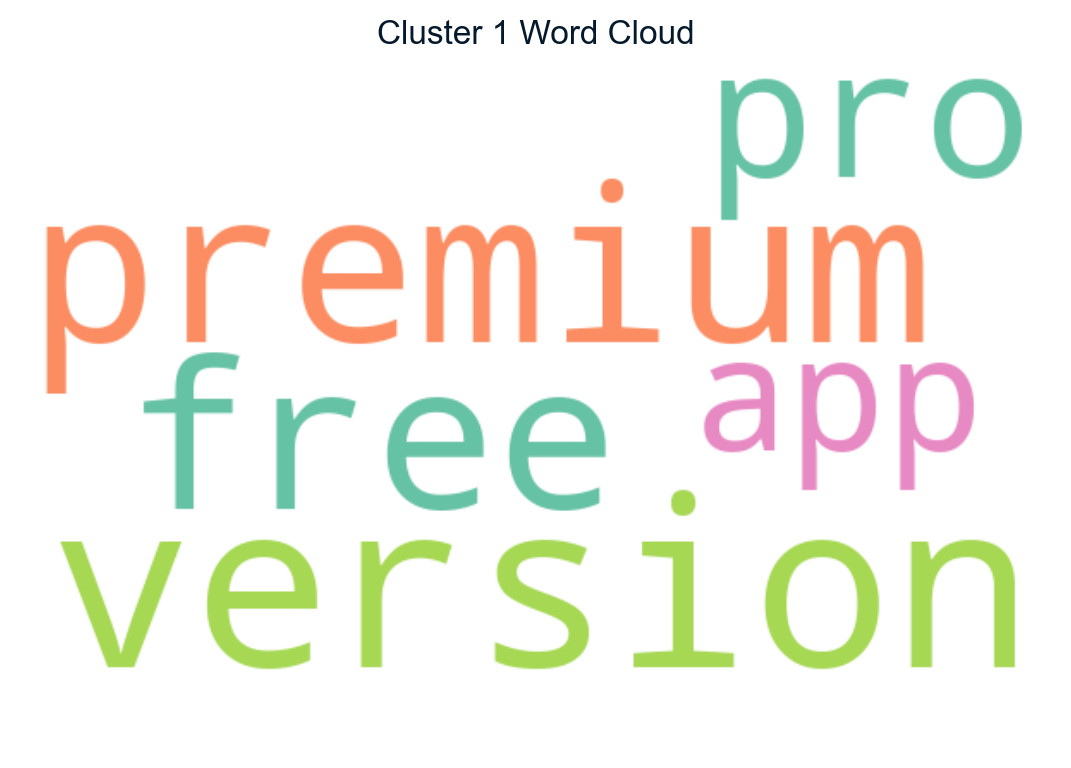

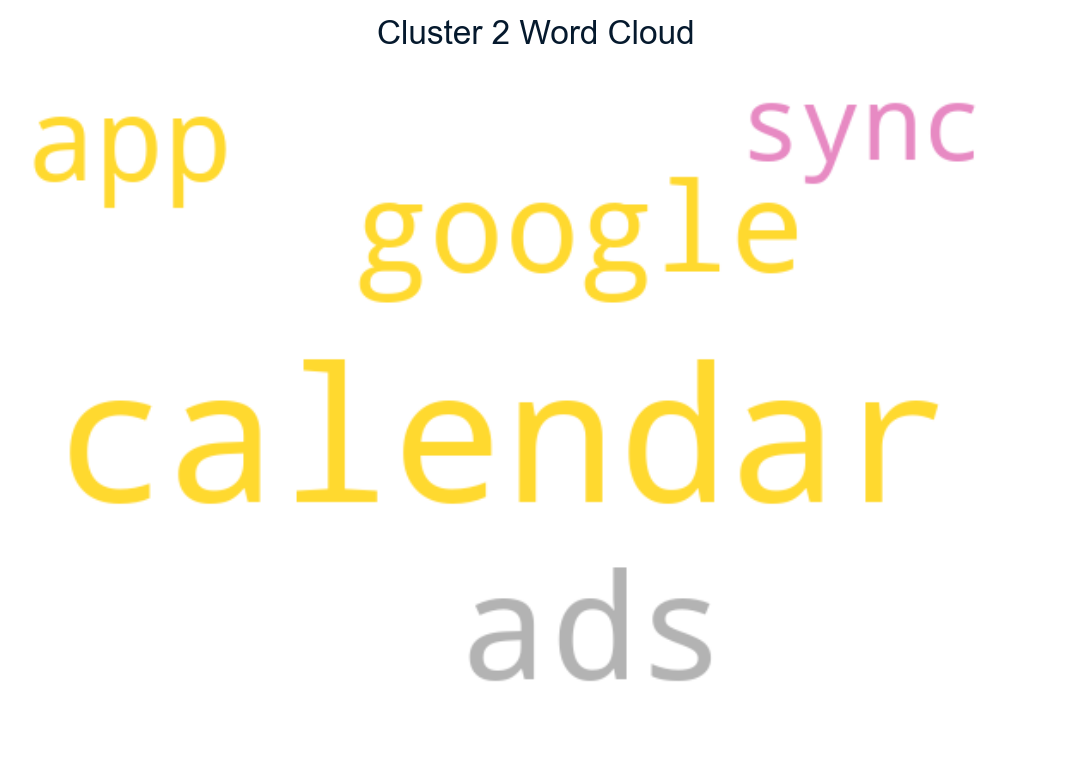

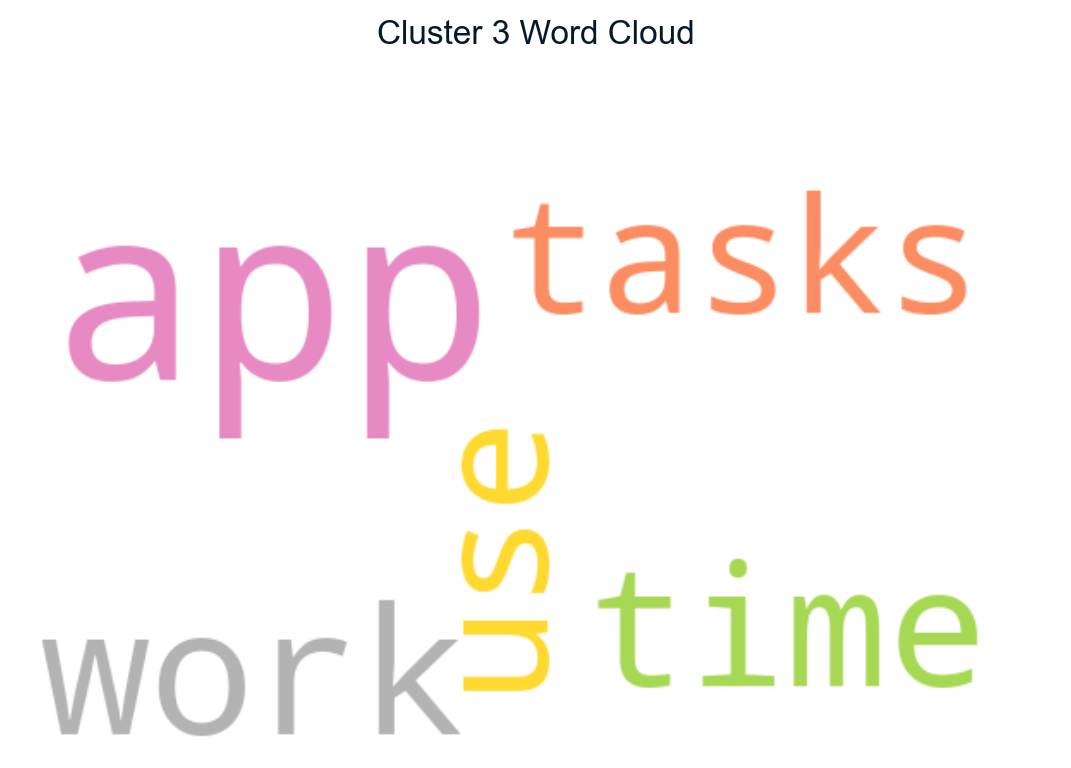

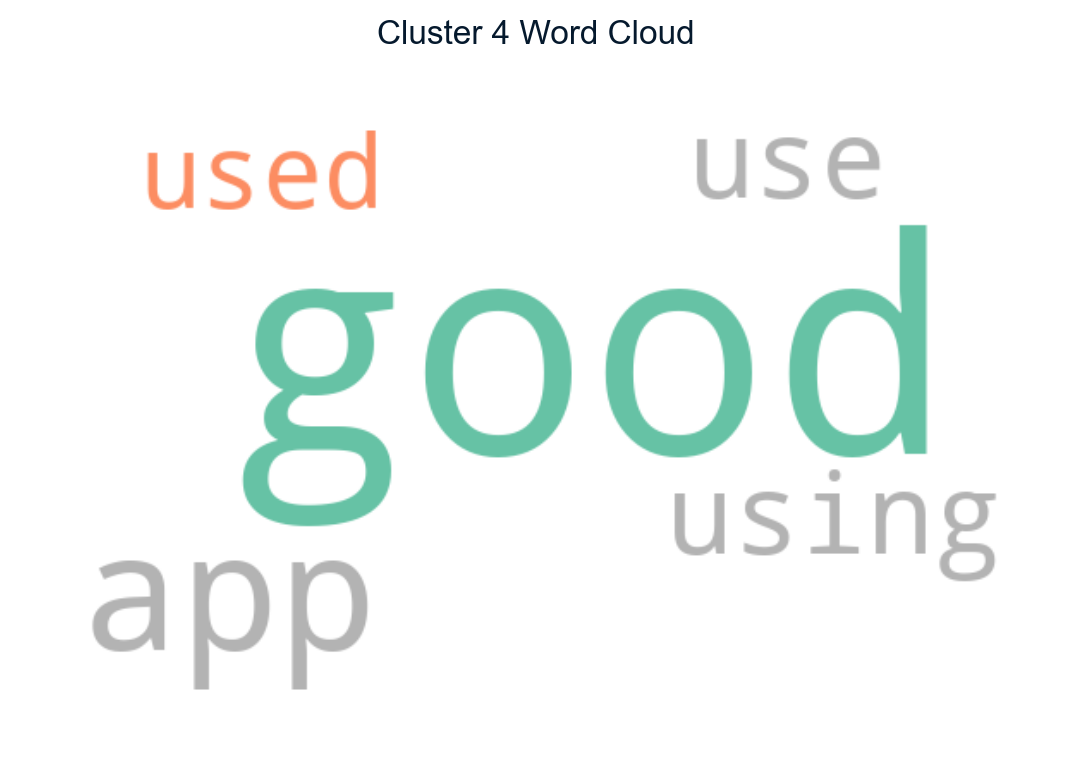

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create one word cloud per cluster
for cluster_label in range(5):
    # Filter terms for this cluster
    cluster_data = topic_terms[topic_terms['category'] == cluster_label]

    # Build a dictionary of term: frequency
    word_freq = dict(zip(cluster_data['term'], cluster_data['frequency']))

    # Create the word cloud
    wc = WordCloud(width=600, height=400, background_color='white', colormap='Set2').generate_from_frequencies(word_freq)

    # Plot
    plt.figure(figsize=(6, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Cluster {cluster_label} Word Cloud")
    plt.tight_layout()
    plt.show()